In [1]:
%pip install --upgrade tensorflow opencv-python-headless pycocotools numpy pandas matplotlib scipy scikit-learn setuptools


  Using cached numpy-2.1.3-cp312-cp312-win_amd64.whl.metadata (60 kB)


In [2]:
import os
import numpy as np
import cv2
from pycocotools.coco import COCO


image_directory_empty = './parkinglots/notbusy'
image_directory_busy = './parkinglots/busy'
image_directory = './parkinglots'

empty_image_files = [os.path.join(image_directory_empty, f) for f in os.listdir(image_directory_empty) if f.endswith(('.png', '.jpg', '.jpeg'))]
busy_image_files = [os.path.join(image_directory_busy, f) for f in os.listdir(image_directory_busy) if f.endswith(('.png', '.jpg', '.jpeg'))]

image_files = empty_image_files + busy_image_files

labels =[]

# 1 for kinda busy, 0 for kinda empty
for image_file in empty_image_files:
  labels.append(0)
for image_file in busy_image_files:
  labels.append(1)


IMG_SIZE = (128, 128)  # resizing images to 128x128 for consistency (from 640x640)

def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0  # normalizing pixel values to [0, 1]
    return img


In [3]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential


def build_model(architecture):
    model = Sequential()
    
    if architecture == 'small':
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
        model.add(MaxPooling2D(2, 2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.3))
    
    elif architecture == 'medium':
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
        model.add(MaxPooling2D(2, 2))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(2, 2))
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
    
    elif architecture == 'large':
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
        model.add(MaxPooling2D(2, 2))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(2, 2))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D(2, 2))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
    
    # Common output layer
    model.add(Dense(2, activation='softmax'))  # output layer for "empty" or "occupied" classes
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

architectures = ['small', 'medium', 'large']


In [4]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator


file_image = [load_and_preprocess_image(img) for img in image_files]

X_train_val, X_test, y_train_val, y_test = train_test_split(file_image, labels, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

X_train = np.array(X_train)
y_train = to_categorical(y_train)


X_val = np.array(X_val)
y_val = to_categorical(y_val)

X_test = np.array(X_test)
y_test = to_categorical(y_test)


results = {}
for arch in architectures:
    print(f"Training model with architecture: {arch}")
    model = build_model(arch)
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    data_gen = ImageDataGenerator( # data augmentation
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    
    history = model.fit(
        data_gen.flow(X_train, y_train, batch_size=32),
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    
  
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    
    results[arch] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    print(f"Test Accuracy for {arch}: {accuracy:.2f}")
    print(f"Test Precision for {arch}: {precision:.2f}")
    print(f"Test Recall for {arch}: {recall:.2f}")
    print(f"Test F1 Score for {arch}: {f1:.2f}")

# Compare results
print("\nComparison of Model Architectures:")
for arch, metrics in results.items():
    print(f"{arch.capitalize()} - Accuracy: {metrics['accuracy']:.2f}")



Training model with architecture: small


d:\VS CODE\ML_Project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\VS CODE\ML_Project\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - accuracy: 0.6387 - loss: 1.8016 - val_accuracy: 0.9514 - val_loss: 0.1528
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 0.9324 - loss: 0.1775 - val_accuracy: 0.8757 - val_loss: 0.2504
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.9803 - loss: 0.0744 - val_accuracy: 0.7405 - val_loss: 0.6426
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - accuracy: 0.9775 - loss: 0.0649 - val_accuracy: 0.9622 - val_loss: 0.1024
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.9823 - loss: 0.0513 - val_accuracy: 1.0000 - val_loss: 0.0099
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 0.9813 - loss: 0.0623 - val_accuracy: 0.8919 - val_loss: 0.2508
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 0.9916 - loss: 0.0352 - val_accuracy: 0.8973 - val_loss: 0.2211
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 0.9860 - loss: 0.0427 - val_accuracy: 0.

d:\VS CODE\ML_Project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\VS CODE\ML_Project\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - accuracy: 0.6598 - loss: 1.2289 - val_accuracy: 0.6919 - val_loss: 0.7016
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - accuracy: 0.9302 - loss: 0.1821 - val_accuracy: 1.0000 - val_loss: 0.0391
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.9581 - loss: 0.1182 - val_accuracy: 0.9622 - val_loss: 0.0866
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - accuracy: 0.9826 - loss: 0.0552 - val_accuracy: 0.9297 - val_loss: 0.1441
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.9866 - loss: 0.0503 - val_accuracy: 0.9459 - val_loss: 0.1716
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.9843 - loss: 0.0526 - val_accuracy: 0.9514 - val_loss: 0.0994
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - accuracy: 0.9910 - loss: 0.0442 - val_accuracy: 0.7838 - val_loss: 0.6075
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Test Accuracy for medium: 0.99
Test Precision for medium: 0.99
T

d:\VS CODE\ML_Project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\VS CODE\ML_Project\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - accuracy: 0.6265 - loss: 0.8529 - val_accuracy: 0.7784 - val_loss: 0.3845
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 0.9719 - loss: 0.1176 - val_accuracy: 0.6486 - val_loss: 1.4783
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - accuracy: 0.9683 - loss: 0.0789 - val_accuracy: 0.8378 - val_loss: 0.3775
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 0.9746 - loss: 0.0923 - val_accuracy: 0.8216 - val_loss: 0.5216
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.9913 - loss: 0.0370 - val_accuracy: 0.8919 - val_loss: 0.2573
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.9927 - loss: 0.0324 - val_accuracy: 0.9243 - val_loss: 0.1604
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.9851 - loss: 0.0477 - val_accuracy: 0.9135 - val_loss: 0.1902
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - accuracy: 0.9822 - loss: 0.0584 - val_accuracy: 0.

In [5]:
new_image_path = './A.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


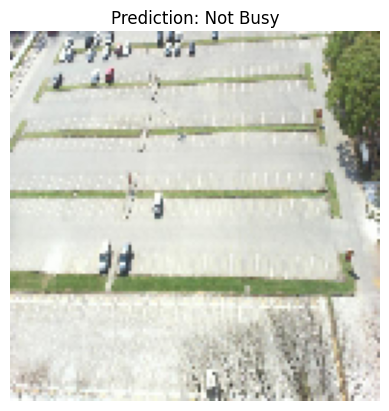

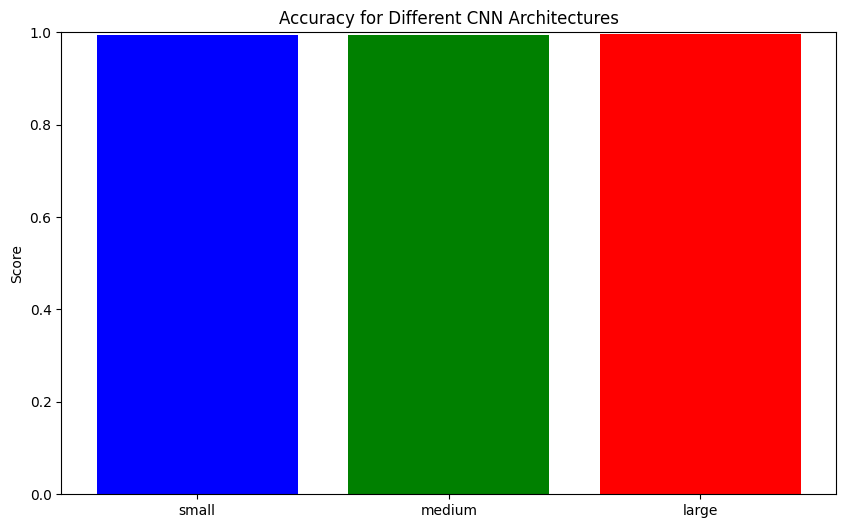

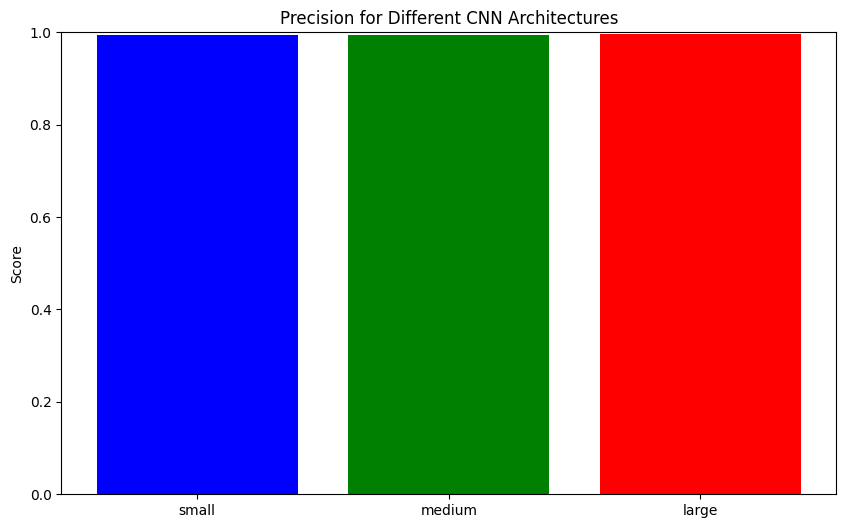

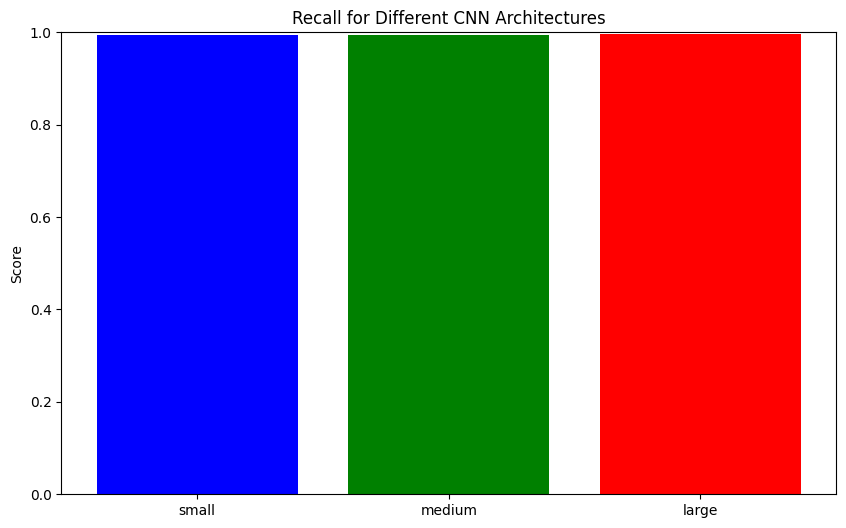

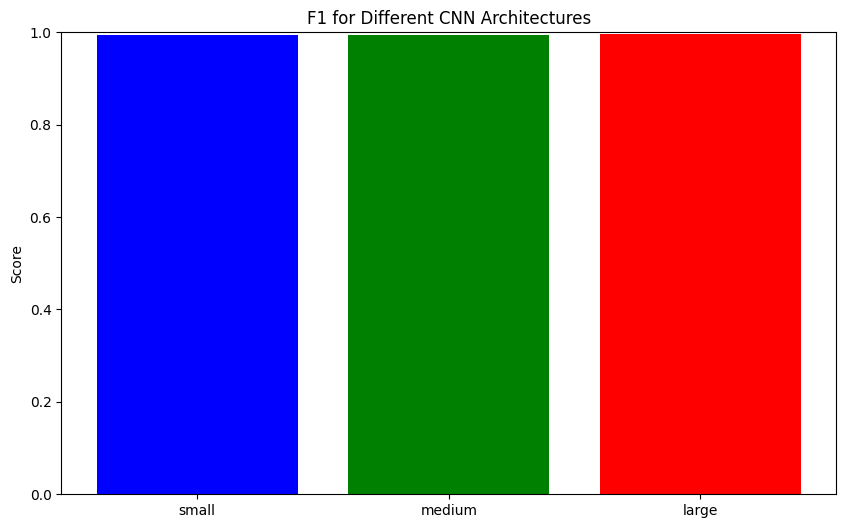

In [6]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt



def visualize_detection(image_path, model):
    img = load_and_preprocess_image(image_path)
    preds = model.predict(np.expand_dims(img, axis=0))
    label = 'Busy' if np.argmax(preds) == 1 else 'Not Busy'
    
    plt.imshow(img)
    plt.title(f'Prediction: {label}')
    plt.axis('off')
    plt.show()

visualize_detection(new_image_path, model)


metrics = ['accuracy', 'precision', 'recall', 'f1']
for metric in metrics:
    values = [results[arch][metric] for arch in architectures]
    plt.figure(figsize=(10, 6))
    plt.bar(architectures, values, color=['blue', 'green', 'red', 'purple'])
    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title(f'{metric.capitalize()} for Different CNN Architectures')
    plt.show()



In [7]:
model.save('./cnn_model.keras')